## Machine Learning with Spark - Lab

## Introduction

In the previous lesson, you saw how to manipulate data with Spark DataFrames as well as create machine learning models. In this lab, you're going to practice loading data, manipulating it, and fitting it in the Spark framework. Afterward, you're going to make use of different visualizations to see if you can get any insights from the model. This dataset is from a Taiwanese financial company, and the task is to determine which individuals are going to default on their credit card based off of characteristics such as limit balance, past payment history, age, marriage status, and sex. Let's get started!

### Objectives

In this lab you will: 

- Load and manipulate data using Spark DataFrames 
- Create a Spark ML pipeline that transforms data and runs over a grid of hyperparameters 

To begin with create a SparkSession and import the `'credit_card_default.csv'` file  into a PySpark DataFrame. 

In [1]:
# import necessary libraries
from pyspark import SparkContext
from pyspark.sql import SparkSession

# initialize Spark Session
spark = SparkSession.builder.master('local').getOrCreate()

# read in csv to a spark dataframe
spark_df = spark.read.csv('credit_card_default.csv', header='true', inferSchema='true')

Check the datatypes to ensure that all columns are the datatype you expect.

In [2]:
spark_df.dtypes

[('ID', 'int'),
 ('LIMIT_BAL', 'double'),
 ('SEX', 'string'),
 ('EDUCATION', 'string'),
 ('MARRIAGE', 'string'),
 ('AGE', 'int'),
 ('PAY_0', 'int'),
 ('PAY_2', 'int'),
 ('PAY_3', 'int'),
 ('PAY_4', 'int'),
 ('PAY_5', 'int'),
 ('PAY_6', 'int'),
 ('BILL_AMT1', 'double'),
 ('BILL_AMT2', 'double'),
 ('BILL_AMT3', 'double'),
 ('BILL_AMT4', 'double'),
 ('BILL_AMT5', 'double'),
 ('BILL_AMT6', 'double'),
 ('PAY_AMT1', 'double'),
 ('PAY_AMT2', 'double'),
 ('PAY_AMT3', 'double'),
 ('PAY_AMT4', 'double'),
 ('PAY_AMT5', 'double'),
 ('PAY_AMT6', 'double'),
 ('default', 'int')]

Check to see how many missing values are in the dataset. This will require using the `.filter()` , `.isNull()`, and `.count()` methods.

In [3]:
for col in spark_df.columns:
    # your code here
    print(f"column {col} {spark_df.filter(spark_df[col].isNull()).count()}")

column ID 0
column LIMIT_BAL 0
column SEX 0
column EDUCATION 0
column MARRIAGE 0
column AGE 0
column PAY_0 0
column PAY_2 0
column PAY_3 0
column PAY_4 0
column PAY_5 0
column PAY_6 0
column BILL_AMT1 0
column BILL_AMT2 0
column BILL_AMT3 0
column BILL_AMT4 0
column BILL_AMT5 0
column BILL_AMT6 0
column PAY_AMT1 0
column PAY_AMT2 0
column PAY_AMT3 0
column PAY_AMT4 0
column PAY_AMT5 0
column PAY_AMT6 0
column default 0


Now, determine how many categories there are in each of the categorical columns.

In [4]:
for column, data_type in spark_df.dtypes:
   # your code here
    if data_type == 'string':
#         print(f"column {column} {data_type}")
        print(f"Feature {column} has: {spark_df.select(column).distinct().collect()}")

Feature SEX has: [Row(SEX='Female'), Row(SEX='Male')]
Feature EDUCATION has: [Row(EDUCATION='High School'), Row(EDUCATION='0'), Row(EDUCATION='5'), Row(EDUCATION='6'), Row(EDUCATION='Other'), Row(EDUCATION='Graduate'), Row(EDUCATION='College')]
Feature MARRIAGE has: [Row(MARRIAGE='0'), Row(MARRIAGE='Other'), Row(MARRIAGE='Married'), Row(MARRIAGE='Single')]


Interesting... it looks like we have some extraneous values in each of our categories. Let's look at some visualizations of each of these to determine just how many of them there are. Create bar plots of the variables `'EDUCATION'` and `'MARRIAGE'` to see how many of the undefined values there are. After doing so, come up with a strategy for accounting for the extra values.

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def barplot_cat_counts(cat_counts, xlabel=None, title=None):
    fig = plt.figure(figsize=(10,8))
    sns.barplot(
        x=[cat_count[0] for cat_count in cat_counts], 
        y=[cat_count[1] for cat_count in cat_counts]
    )
    if xlabel is not None:
        plt.xlabel(xlabel)
    if title is not None:
        plt.title(title)
    plt.ylabel('Count')
    fig.tight_layout()
    plt.show()

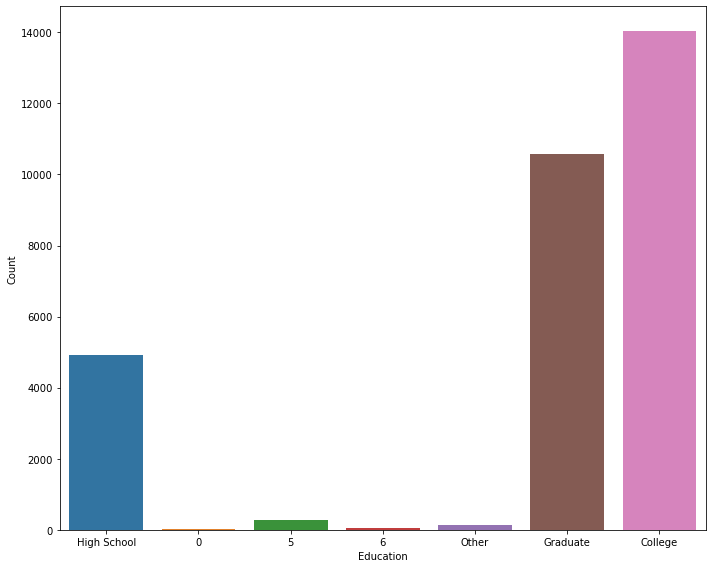

In [6]:
## plotting the categories for education
barplot_cat_counts(
    spark_df.groupBy('EDUCATION').count().collect(),
    xlabel='Education'
)

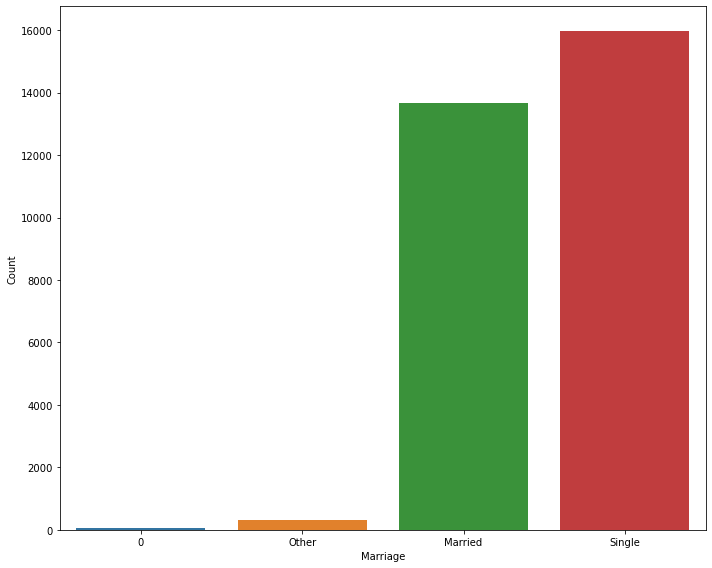

In [7]:
barplot_cat_counts(
    spark_df.groupBy('MARRIAGE').count().collect(),
    xlabel='Marriage'
)

It looks like there are barely any of the 0 and 5 categories. We can go ahead and throw them into the "Other" category since it's already operating as a catchall here. Similarly, the category "0" looks small, so let's throw it in with the "Other" values. You can do this by using a method called `.when()` from PySpark in conjunction with `.withColumn()` and `.otherwise()`.  

In [8]:
from pyspark.sql.functions import when

## changing the values in the education column
spark_df_edu_0_5_6_to_Other = spark_df.withColumn(
    'EDUCATION',
    when(spark_df.EDUCATION=='0', 'Other') \
        .when(spark_df.EDUCATION=='5', 'Other') \
        .when(spark_df.EDUCATION=='6', 'Other') \
        .otherwise(spark_df['EDUCATION'])
)

## changing the values in the marriage column
spark_df_done = spark_df_edu_0_5_6_to_Other.withColumn(
    'MARRIAGE',
    when(spark_df.MARRIAGE=='0', 'Other') \
        .otherwise(spark_df['MARRIAGE'])
)

In [9]:
spark_df_done.head()

Row(ID=2, LIMIT_BAL=120000.0, SEX='Female', EDUCATION='College', MARRIAGE='Single', AGE=26, PAY_0=-1, PAY_2=2, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=2, BILL_AMT1=2682.0, BILL_AMT2=1725.0, BILL_AMT3=2682.0, BILL_AMT4=3272.0, BILL_AMT5=3455.0, BILL_AMT6=3261.0, PAY_AMT1=0.0, PAY_AMT2=1000.0, PAY_AMT3=1000.0, PAY_AMT4=1000.0, PAY_AMT5=0.0, PAY_AMT6=2000.0, default=1)

Now let's take a look at all the values contained in the categorical columns of the DataFrame: 

In [10]:
for column, data_type in spark_df_done.dtypes:
   # your code here
    if data_type == 'string':
#         print(f"column {column} {data_type}")
        print(f"Feature {column} has: {spark_df_done.select(column).distinct().collect()}")

Feature SEX has: [Row(SEX='Female'), Row(SEX='Male')]
Feature EDUCATION has: [Row(EDUCATION='High School'), Row(EDUCATION='Other'), Row(EDUCATION='Graduate'), Row(EDUCATION='College')]
Feature MARRIAGE has: [Row(MARRIAGE='Other'), Row(MARRIAGE='Married'), Row(MARRIAGE='Single')]


Much better. Now, let's do a little more investigation into our target variable before diving into the machine learning aspect of this project.

##  EDA

Let's first look at the overall distribution of class balance of the default and not default labels. Create a barplot to compare the number of defaults vs. non-defaults. This will require using `.groupBy()` as well as an aggregation method.

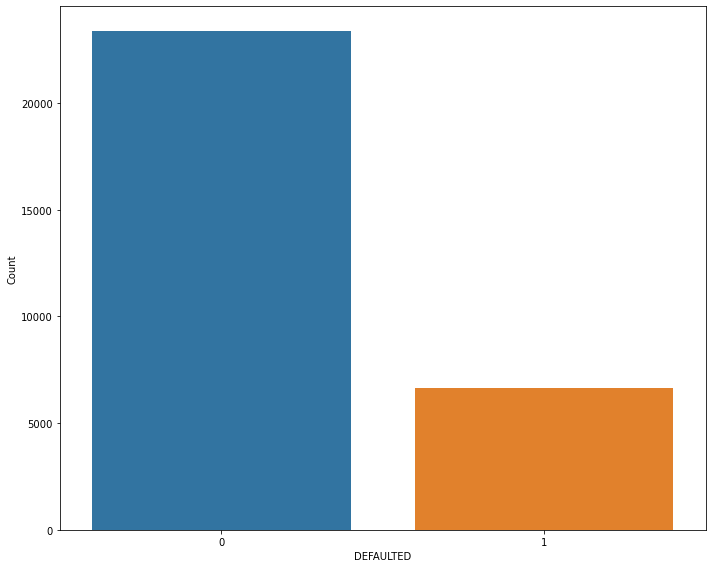

In [11]:
barplot_cat_counts(
    spark_df_done.groupBy('default').count().collect(),
    xlabel='DEFAULTED'
)

Let's also visualize the difference in default rate between males and females in this dataset.

In [12]:
# perform a groupby for default and sex
dflt_sex_cat_counts = spark_df_done.groupBy(['default', 'SEX']).count().collect()
dflt_sex_cat_counts

[Row(default=1, SEX='Female', count=3762),
 Row(default=0, SEX='Male', count=9015),
 Row(default=1, SEX='Male', count=2873),
 Row(default=0, SEX='Female', count=14349)]

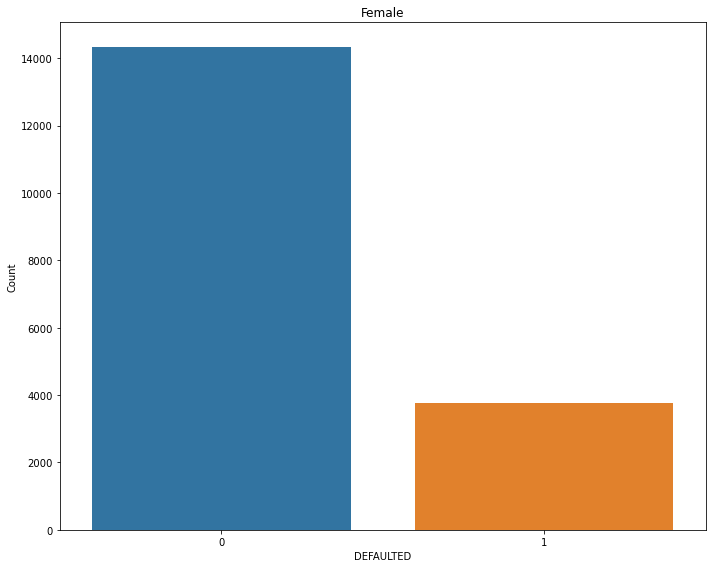

In [13]:
spark_df_done.createOrReplaceTempView("cc_dflt")

# make barplot for female default v no default rate
spdf_female = spark.sql("SELECT * FROM cc_dflt WHERE SEX=='Female'")
barplot_cat_counts(
    spdf_female.groupBy('default').count().collect(),
    xlabel='DEFAULTED',
    title='Female'
)

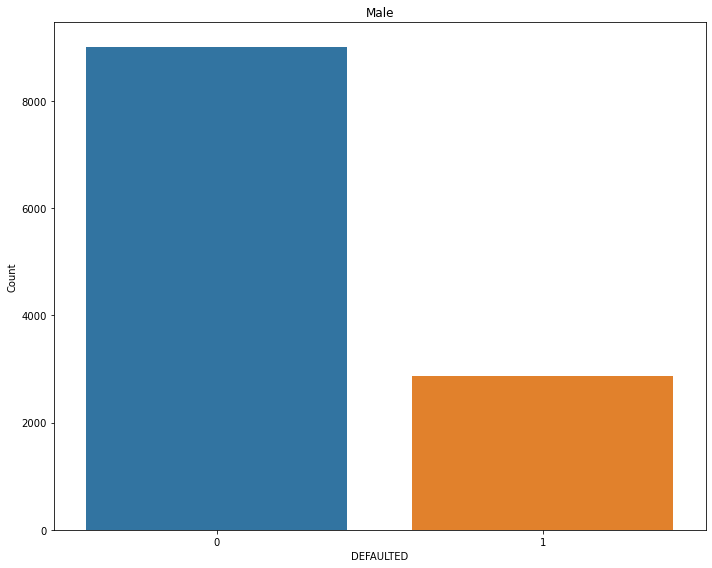

In [14]:
# make barplot for male default v no default rate
spdf_male = spark.sql("SELECT * FROM cc_dflt WHERE SEX=='Male'")
barplot_cat_counts(
    spdf_male.groupBy('default').count().collect(),
    xlabel='DEFAULTED',
    title='Male'
)

It looks like males have an ever so slightly higher default rate than females.

## Onto the Machine Learning!

Now, it's time to fit the data to the PySpark machine learning model pipeline. You will need:

* 3 StringIndexers (for each categorical feature)
* A OneHotEncoderEstimator (to encode the newly indexed strings into categorical variables)
* A VectorAssembler (to combine all features into one SparseVector)

All of these initialized estimators should be stored in a list.

In [15]:
# importing the necessary modules
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder

# creating the string indexers
string_indexers = []
non_cat_predictors = []
for column, data_type in spark_df_done.dtypes:
    if data_type == 'string':
        string_indexers.append(StringIndexer(inputCol=column, outputCol=column+'_idxd', handleInvalid='keep'))
    else:
        non_cat_predictors.append(column)
non_cat_predictors.remove('ID')
non_cat_predictors.remove('default')
# print(f"non_cat_predictors ({len(non_cat_predictors)}): {non_cat_predictors}")

output_indexed_cols = [string_indexer.getOutputCol() for string_indexer in string_indexers]
# print(f"output_indexed_cols ({len(output_indexed_cols)}): {output_indexed_cols}")
ohe = OneHotEncoder(
    inputCols=output_indexed_cols,
    outputCols=[col + '_ohe' for col in output_indexed_cols],
    dropLast=True,
    handleInvalid='error'
)
# print(f"ohe.getDropLast(): {ohe.getDropLast()}")
# print(f"ohe.getOutputCols() ({len(ohe.getOutputCols())}): {ohe.getOutputCols()}")

# features to be included in the model
model_predictors = non_cat_predictors.copy()

# adding the categorical features
model_predictors.extend(ohe.getOutputCols())
print(f"model_predictors ({len(model_predictors)}): {model_predictors}")

# putting all of the features into a single vector
vector_assembler = VectorAssembler(inputCols=model_predictors, outputCol='features_vector')

model_predictors (23): ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_idxd_ohe', 'EDUCATION_idxd_ohe', 'MARRIAGE_idxd_ohe']


Alright! Now let's see if that worked. Let's investigate how it transforms your dataset. Put all of the stages in a Pipeline and fit it to your data. Look at the features column. Did you obtain the number of features you expected?

In [16]:
from pyspark.ml.pipeline import Pipeline

pipeline = Pipeline(stages=string_indexers+[ohe]+[vector_assembler])
pipeline_model = pipeline.fit(spark_df_done)
transformed_data = pipeline_model.transform(spark_df_done)
spdf_transformed_data = transformed_data.select('features_vector')

In [17]:
cols_expected = non_cat_predictors + [
    'SEX_idxd_ohe_Female', 
    'EDUCATION_idxd_ohe_College', 
    'EDUCATION_idxd_ohe_Graduate',
    'EDUCATION_idxd_ohe_High School',
    'MARRIAGE_idxd_ohe_Single',
    'MARRIAGE_idxd_ohe_Married'
]

print(f"cols expected ({len(cols_expected)}):")
for col_expected in cols_expected:
    print(f"\t{col_expected}")

cols expected (26):
	LIMIT_BAL
	AGE
	PAY_0
	PAY_2
	PAY_3
	PAY_4
	PAY_5
	PAY_6
	BILL_AMT1
	BILL_AMT2
	BILL_AMT3
	BILL_AMT4
	BILL_AMT5
	BILL_AMT6
	PAY_AMT1
	PAY_AMT2
	PAY_AMT3
	PAY_AMT4
	PAY_AMT5
	PAY_AMT6
	SEX_idxd_ohe_Female
	EDUCATION_idxd_ohe_College
	EDUCATION_idxd_ohe_Graduate
	EDUCATION_idxd_ohe_High School
	MARRIAGE_idxd_ohe_Single
	MARRIAGE_idxd_ohe_Married


In [18]:
# credit to https://stackoverflow.com/a/42959818 for this solution
from itertools import chain
def extract_feature_names_from_transformed_data(transformed_data):
    return sorted((attr["idx"], attr["name"]) for attr in (chain(*transformed_data.schema[-1].metadata["ml_attr"]["attrs"].values())))

In [19]:
print(f"{spdf_transformed_data.head()}\n")

extracted_feat_names = extract_feature_names_from_transformed_data(transformed_data)
print(f"transformed/output cols ({len(extracted_feat_names)}):")
for idx, feat_name in extracted_feat_names:
    print(f"\t{feat_name}")

Row(features_vector=SparseVector(29, {0: 120000.0, 1: 26.0, 2: -1.0, 3: 2.0, 7: 2.0, 8: 2682.0, 9: 1725.0, 10: 2682.0, 11: 3272.0, 12: 3455.0, 13: 3261.0, 15: 1000.0, 16: 1000.0, 17: 1000.0, 19: 2000.0, 20: 1.0, 22: 1.0, 26: 1.0}))

transformed/output cols (29):
	LIMIT_BAL
	AGE
	PAY_0
	PAY_2
	PAY_3
	PAY_4
	PAY_5
	PAY_6
	BILL_AMT1
	BILL_AMT2
	BILL_AMT3
	BILL_AMT4
	BILL_AMT5
	BILL_AMT6
	PAY_AMT1
	PAY_AMT2
	PAY_AMT3
	PAY_AMT4
	PAY_AMT5
	PAY_AMT6
	SEX_idxd_ohe_Female
	SEX_idxd_ohe_Male
	EDUCATION_idxd_ohe_College
	EDUCATION_idxd_ohe_Graduate
	EDUCATION_idxd_ohe_High School
	EDUCATION_idxd_ohe_Other
	MARRIAGE_idxd_ohe_Single
	MARRIAGE_idxd_ohe_Married
	MARRIAGE_idxd_ohe_Other


In [20]:
def compare_extracted_to_expected_feats(extracted_feat_names, cols_expected):
    if len(extracted_feat_names) != len(cols_expected):
        if len(cols_expected) > len(extracted_feat_names):
            (bigger_set, smaller_set) = (set(cols_expected), set(map(lambda t: t[1], extracted_feat_names)))
            (s_bigger_set, s_smaller_set) = ("cols expected", "transformed/output cols")
        else:
            (bigger_set, smaller_set) = (set(map(lambda t: t[1], extracted_feat_names)), set(cols_expected))
            (s_bigger_set, s_smaller_set) = ("transformed/output cols", "cols expected")
        extra_cols = bigger_set - smaller_set
        print(f"{s_bigger_set} has {len(extra_cols)} more cols than {s_smaller_set}:")
        for extra_col in extra_cols:
            print(f"\t{extra_col}")
    else:
        print(f"transformed/output and expected cols are the same")

In [21]:
compare_extracted_to_expected_feats(extracted_feat_names, cols_expected)

transformed/output cols has 3 more cols than cols expected:
	SEX_idxd_ohe_Male
	MARRIAGE_idxd_ohe_Other
	EDUCATION_idxd_ohe_Other


In [22]:
# note that it appears there is a bug in OneHotEncoder: dropLast=True is not having any effect
#    so let's build our own custom Transformer to accomplish what OneHotEncoder.dropLast is supposed to do
#    until the bug in OneHotEncoder is fixed, this should be used AFTER call transform on a OneHotEncoder object
#       in order to accomplish what dropLast=True should

from pyspark.ml import Transformer
from typing import Iterable
from pyspark.sql import DataFrame
from pyspark.sql.types import Row
from pyspark.sql import functions as pssqlfuncs
from pyspark.sql.types import IntegerType, DoubleType, ArrayType

from pyspark.ml.feature import VectorSlicer
from pyspark.ml.functions import vector_to_array
from pyspark.ml.linalg import Vectors, VectorUDT

class OneHotEncodedLastDropper(Transformer):
    """
    A custom Transformer which drops the last column after OneHotEncoder.transform() has been applied.
    """

    def __init__(self, ohe: OneHotEncoder):
        super(OneHotEncodedLastDropper, self).__init__()
        self.ohe = ohe
        
    def _transform(self, df: DataFrame) -> DataFrame:
        for ohe_col in self.ohe.getOutputCols():
            if ohe_col in df.columns:
                # here is the secret sauce wherein we explode the VectorUDT, drop the last col
                #    then we put the remaining cols back into a VectorUDT in the dataframe
                rdd_new_ohe_col = df[['ID', ohe_col]].rdd.map(lambda r: [r[0], Vectors.dense(r[1].toArray().tolist()[:-1])])
                df_new_ohe_col = rdd_new_ohe_col.toDF(['ID', ohe_col])
                df_ohe_col_dropped = df.drop(ohe_col)
                df_ohe_col_dropped.createOrReplaceTempView("DF_OHE_COL_DROPPED")
                df_new_ohe_col.createOrReplaceTempView("DF_NEW_OHE_COL")
                df_new = spark.sql(f"""
                    SELECT 
                        D.*, N.{ohe_col}
                    FROM 
                        DF_OHE_COL_DROPPED D, DF_NEW_OHE_COL N 
                    WHERE D.ID == N.ID
                """)
                df = df_new
            
        return df

In [23]:
# # creating the string indexers
# string_indexers = []
# non_cat_predictors = []
# for column, data_type in spark_df_done.dtypes:
#     if data_type == 'string':
#         string_indexers_2.append(StringIndexer(inputCol=column, outputCol=column+'_idxd', handleInvalid='keep'))
#     else:
#         non_cat_predictors_2.append(column)
# non_cat_predictors_2.remove('ID')
# non_cat_predictors_2.remove('default') # 'default' is the target

# output_indexed_cols = [string_indexer.getOutputCol() for string_indexer in string_indexers]
# # print(f"output_indexed_cols ({len(output_indexed_cols)}): {output_indexed_cols}")
# ohe = OneHotEncoder(
#     inputCols=output_indexed_cols,
#     outputCols=[col + '_ohe' for col in output_indexed_cols],
#     dropLast=True, # this does nothing
#     handleInvalid='error'
# )

ohe_last_dropper = OneHotEncodedLastDropper(ohe)

# # features to be included in the model
# model_predictors = non_cat_predictors.copy()

# # adding the categorical features
# model_predictors.extend(ohe.getOutputCols())

# # putting all of the features into a single vector
# vector_assembler = VectorAssembler(inputCols=model_predictors, outputCol='features_vector')

pipeline_2 = Pipeline(stages=string_indexers+[ohe]+[ohe_last_dropper]+[vector_assembler])
pipeline_model_2 = pipeline_2.fit(spark_df_done)
transformed_data_2 = pipeline_model_2.transform(spark_df_done)
spdf_transformed_data_2 = transformed_data_2.select('features_vector')

In [24]:
print(f"{spdf_transformed_data_2.head()}\n")

extracted_feat_names_2 = extract_feature_names_from_transformed_data(transformed_data_2)
print(f"transformed/output cols ({len(extracted_feat_names_2)}):")
for idx, feat_name in extracted_feat_names_2:
    print(f"\t{feat_name}")

Row(features_vector=SparseVector(26, {0: 50000.0, 1: 23.0, 8: 47620.0, 9: 41810.0, 10: 36023.0, 11: 28967.0, 12: 29829.0, 13: 30046.0, 14: 1973.0, 15: 1426.0, 16: 1001.0, 17: 1432.0, 18: 1062.0, 19: 997.0, 23: 1.0, 24: 1.0}))

transformed/output cols (26):
	LIMIT_BAL
	AGE
	PAY_0
	PAY_2
	PAY_3
	PAY_4
	PAY_5
	PAY_6
	BILL_AMT1
	BILL_AMT2
	BILL_AMT3
	BILL_AMT4
	BILL_AMT5
	BILL_AMT6
	PAY_AMT1
	PAY_AMT2
	PAY_AMT3
	PAY_AMT4
	PAY_AMT5
	PAY_AMT6
	SEX_idxd_ohe_0
	EDUCATION_idxd_ohe_0
	EDUCATION_idxd_ohe_1
	EDUCATION_idxd_ohe_2
	MARRIAGE_idxd_ohe_0
	MARRIAGE_idxd_ohe_1


In [25]:
compare_extracted_to_expected_feats(extracted_feat_names_2, cols_expected)

transformed/output and expected cols are the same


## Fitting Machine Learning Models
That looks good! Now let's go ahead and fit data to different machine learning models. To evaluate these models, you should use the `BinaryClassificationEvaluator`. Below is an import of all the classes and libraries you'll need in the remainder of this lab.

In [26]:
from pyspark.ml.classification import GBTClassifier, DecisionTreeClassifier, LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np

### Logistic Regression

First, we'll try with a simple Logistic Regression Model:

* instantiate a logistic regression model
* add it to the stages list
* instantiate a new Pipeline estimator (not fit) with all of the stages
* instantiate an `BinaryClassificationEvaluator`
* create parameters to gridsearch through using `ParamGridBuilder`
* Instantiate and fit a `CrossValidator` 

In [27]:
# your code here
log_reg = LogisticRegression(featuresCol='features_vector', labelCol='default')
# pipeline = Pipeline(stages=string_indexers+[ohe, ohe_last_dropper, vector_assembler, log_reg])
pipeline = Pipeline(stages=string_indexers+[ohe, vector_assembler, log_reg])
bin_class_eval = BinaryClassificationEvaluator(labelCol='default', metricName='areaUnderROC')

log_reg_params = ParamGridBuilder() \
    .addGrid(log_reg.regParam, [0.0,0.2,0.5,1.0]) \
    .addGrid(log_reg.standardization, [True,False]) \
    .build()
cv = CrossValidator(
    estimator=pipeline, 
    estimatorParamMaps=log_reg_params,
    evaluator=bin_class_eval,
    parallelism=4
)
model = cv.fit(spark_df_done)

Determine how well your model performed by looking at the evaluator metrics. If you tried multiple parameters, which performed best?

In [28]:
# print out the AUC of your best model as well as the parameters of your best model
idx_best_model = np.argmax(model.avgMetrics)
print(f"best params: {log_reg_params[idx_best_model]}")
print(f"AUC: {model.avgMetrics[idx_best_model]}")

best params: {Param(parent='LogisticRegression_4851edccdd68', name='regParam', doc='regularization parameter (>= 0).'): 0.0, Param(parent='LogisticRegression_4851edccdd68', name='standardization', doc='whether to standardize the training features before fitting the model.'): True}
AUC: 0.7244476084393011


#### Now try this again with other classifiers. Try and create a function that will allow you to easily test different models with different parameters. This function is optional, but it should allow for your code to be far more D.R.Y. The function should return the fitted cross-validated model as well as print out the performance metrics of the best performing model and the best parameters.

In [29]:
# create function to cross validate models with different parameters
def build_model(df, label_col, ml_algo, preprocessing_stages, param_grid, eval_metric='areaUnderROC', parallelism=4):
    pipeline = Pipeline(stages=preprocessing_stages+[ml_algo])
    bin_class_eval = BinaryClassificationEvaluator(labelCol=label_col, metricName=eval_metric)
    cross_validator = CrossValidator(
        estimator=pipeline, 
        estimatorParamMaps=param_grid,
        evaluator=bin_class_eval,
        parallelism=parallelism
    )
    cv_model = cross_validator.fit(df)
    
    idx_max_metric_val = np.argmax(cv_model.avgMetrics)
    print(f"best params: {param_grid[idx_max_metric_val]}")
    print(f"{eval_metric}: {cv_model.avgMetrics[idx_max_metric_val]}")
    
    return cv_model

Train a Random Forest classifier and determine the best performing model with the best parameters. This might take a while! Be smart about how you use parallelization here.

In [30]:
# code to train Random Forest Classifier
# ⏰ This cell may take a long time to run
rf_clf = RandomForestClassifier(featuresCol='features_vector', labelCol='default')
rf_clf_params = ParamGridBuilder() \
    .addGrid(rf_clf.maxDepth, [5,10]) \
    .addGrid(rf_clf.numTrees, [20,50,100,200]) \
    .build()

rf_clf_cv_model = build_model(
    spark_df_done,
    label_col='default',
    ml_algo=rf_clf,
#     preprocessing_stages=string_indexers+[ohe,ohe_last_dropper,vector_assembler],
    preprocessing_stages=string_indexers+[ohe,vector_assembler],
    param_grid=rf_clf_params
)

best params: {Param(parent='RandomForestClassifier_9ddcbfaa7f37', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10, Param(parent='RandomForestClassifier_9ddcbfaa7f37', name='numTrees', doc='Number of trees to train (>= 1).'): 200}
areaUnderROC: 0.7789673954023715


Now train a Gradient Boosting Classifier. **This might take a very long time depending on the number of parameters you are training**

In [31]:
# code to train Gradient Boosting Classifier
# ⏰ This cell may take a long time to run
gbt_clf = GBTClassifier(featuresCol='features_vector', labelCol='default')
gbt_clf_params = ParamGridBuilder() \
    .addGrid(gbt_clf.maxDepth, [1,5]) \
    .addGrid(gbt_clf.maxIter, [20,50,100]) \
    .build()

gbt_clf_cv_model = build_model(
    spark_df_done,
    label_col='default',
    ml_algo=gbt_clf,
#     preprocessing_stages=string_indexers+[ohe,ohe_last_dropper,vector_assembler],
    preprocessing_stages=string_indexers+[ohe,vector_assembler],
    param_grid=gbt_clf_params
)

best params: {Param(parent='GBTClassifier_af30bd127fe6', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5, Param(parent='GBTClassifier_af30bd127fe6', name='maxIter', doc='max number of iterations (>= 0).'): 20}
areaUnderROC: 0.7769977316061966


It looks like the optimal performing model is the Random Forest Classifier Model because it has the highest AUC!

## Level Up (Optional)

* Create ROC curves for each of these models
* Try the multi-layer perceptron classifier algorithm. You will soon learn about what this means in the neural network section!

## Summary

If you've made it thus far, congratulations! Spark is an in-demand skill, but it is not particularly easy to master. In this lesson, you fit multiple different machine learning pipelines for a classification problem. If you want to take your Spark skills to the next level, connect to a distributed cluster using a service like AWS or Databricks and perform these Spark operations on the cloud.